# NER with LSTM

지난 포스트에서는 개체명 인식에 Conditional Random Field(CRF)를 적용해보았습니다. 

첫번째 포스트에서의 RandomForest기법을 사용한 것에 비해, f1 score가 확연히 좋아진 것을 확인할 수 있었습니다. 

이번 글부터느 단순한 머신러닝 기반이 아닌, 딥러닝을 이용해 NER을 수행하겠습니다. 

사용할 신경망 모델은 시퀀스처리에 뛰어난 성능을 보인다고 알려진 LSTM입니다. 

LSTM은 순환신경망(RNN)의 기억력을 높이기 위해 cell state와 gate를 추가한 모델입니다. 
자세한 내용은 [여기](https://)를 참고하세요. 

앞으로의 포스트 목록은 다음과 같습니다:
1. Introduction To NER
2. NER With CRF In Python
**3. NER with LSTM**
4. Sequence Tagging With A LSTM-CRF
... 

이번 포스트는 Andrew Ng 교수님의 [CS230 포스트](https://cs230.stanford.edu/blog/namedentity/)를 참고했습니다. 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/ner_dataset.csv", encoding = 'latin1')

In [0]:
# 빈 값을 앞 데이터로부터 채우기
# https://ordo.tistory.com/59

data = data.fillna(method = "ffill")

# Data Analysis

In [0]:
data.tail(5)

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [0]:
words = list(set(data["Word"].values))
words.append("EOSPAD")
n_words = len(words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)

In [0]:
print("n_Tags: ", n_tags)
print(tags)

print("n_words :", n_words)

n_Tags:  17
['I-geo', 'B-per', 'B-gpe', 'B-org', 'B-geo', 'I-per', 'I-org', 'I-gpe', 'B-eve', 'I-nat', 'I-tim', 'B-tim', 'I-eve', 'B-nat', 'O', 'I-art', 'B-art']
n_words : 35179


"ner_dataset" 파일은 :

- 47,959개의 문장으로 이루어져있습니다. 

- 전체 파일은 마지막에 추가한 EOSPAD 토큰을 포함하여 35,179개의 개별 단어로 이루어져있습니다. 

- 각 단어들은 17개의 tag로 분류됩니다. 대부분의  단어들은 '0'으로 태깅되어있습니다. NER의 성능은 '0'이외의 16가지 tag를 제대로 해내느냐에 달려있습니다.

그렇다면 이제 데이터를 [문장] : [POS] : [NER]의 형태로 만들어봅시다. 

지난 포스트와 마찬가지로 Python pandas의 *groupby()* 연산자를 활용하겠습니다. 

In [0]:
class GetSentencePair(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False

        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(), 
                                                      s["POS"].values.tolist(), 
                                                      s["Tag"].values.tolist())]

        self.group = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.group]
    
    def get_next(self):
        try: 
            s = self.group["Sentence: {}".format(self.n_next)]
            self.n_sent +=1
            return s
        except:
            return None

In [0]:
GetSent = GetSentencePair(data)
sent = GetSent.get_next()

sentences = GetSent.sentences

In [0]:
print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
from collections import Counter

tag_word = dict(Counter(list(data["Tag"].values)))
print(tag_word)

{'O': 887908, 'B-geo': 37644, 'B-gpe': 15870, 'B-per': 16990, 'I-geo': 7414, 'B-org': 20143, 'I-org': 16784, 'B-tim': 20333, 'B-art': 402, 'I-art': 297, 'I-per': 17251, 'I-gpe': 198, 'I-tim': 6528, 'B-nat': 201, 'B-eve': 308, 'I-eve': 253, 'I-nat': 51}


데이터의 형태를 바꾸어주었으니, 시각화를 진행하도록 하겠습니다. 

사용할 라이브러리는 맷플롯립(matplotlib)입니다. 


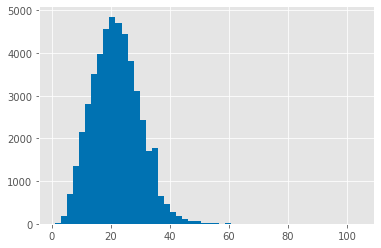

In [0]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

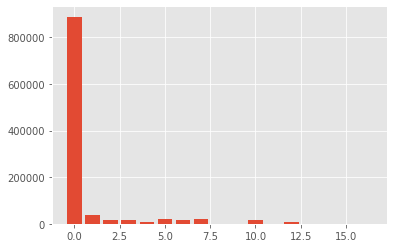

In [0]:
plt.style.use('ggplot')
plt.bar(range(len(tag_word)), list(tag_word.values()))
plt.show()

# 전처리

LSTM 레이어에 데이터를 보내기 전에, 간단한 전처리를 통해 문장들을 바꾸어야합니다. 

1. Encoding
2. Padding

자연어처리(NLP)에서 문장은 숫자로 표기됩니다. 예를 들어, 우리의 단어사전이 `{'is':1, 'John':2, 'Where':3, '.':4, '?':5}`라면, 문장 “Where is John ?”은 `[3,1,2,5]`로 표시될 것입니다. 이를 Encoding이라고 합니다. 

신경망에 데이터를 넘겨주기 전에, 모든 input을 같은 길이로 맞춰주는 Padding 절차가 필수적입니다. 
따라서, 여기서는 모든 문장들 중 가장 긴 길이를 기준으로 패딩을 진행하겠습니다!

In [0]:
# encoding을 위한 mapping dict

max_len = max([len(s) for s in sentences])

word2idx = {w:i+1 for i,w in enumerate(words)}
tag2idx = {t:i+1 for i,t in enumerate(tags)}

print(tag2idx)

{'I-geo': 1, 'B-per': 2, 'B-gpe': 3, 'B-org': 4, 'B-geo': 5, 'I-per': 6, 'I-org': 7, 'I-gpe': 8, 'B-eve': 9, 'I-nat': 10, 'I-tim': 11, 'B-tim': 12, 'I-eve': 13, 'B-nat': 14, 'O': 15, 'I-art': 16, 'B-art': 17}


In [0]:
print(words)

['Investors', 'classify', 'Humberto', 'Hoop', 'feasibility', 'Rica', 'radiological', 'embarrassment', 'role', 'trouble', 'snow-crusted', 'River', 'AM', 'G20', '03-Apr', 'Berruti', 'Vazquez', 'robbers', 'personally', 'Awareness', 'Guatemalans', 'famed', 'Margraten', 'Mainichi', 'Jokhang', 'unsealed', 'revise', 'electing', 'preserving', 'guarantee', '69-43', 'Doan', 'regardless', '1563', 'Refineria', 'emergencies', 'eradicated', '184', 'Anti-India', 'measles', 'no-go', 'Hares', '4-0', 'disclaimer', 'nuts', 'gag', 'Azur', 'sever', 'for', 'aggressively', 'heave', 'excellent', 'Vasilily', 'anonymous', 'Aweys', 'stuck', 'spouses', 'relying', '7.75', 'devolution', 're-sales', '1,70,000', 'Mohammed', 'Juba', 'PET', 'virtuosity', 'accept', 'reversed', '820', 'sons', 'worth', 'brigade', 'sneaking', 'quarter-century', 'Mhawesh', 'notifying', 'Jose', 'Miliband', 'perch', 'Kikkan', '1863', 'funny', 'planned', '38.875', 'rowdy', 'Kandill', 'considerable', 'Islamist-rooted', 'jailing', 'None', 'Fatma

In [0]:
print(word2idx)

{'Investors': 1, 'classify': 2, 'Humberto': 3, 'Hoop': 4, 'feasibility': 5, 'Rica': 6, 'radiological': 7, 'embarrassment': 8, 'role': 9, 'trouble': 10, 'snow-crusted': 11, 'River': 12, 'AM': 13, 'G20': 14, '03-Apr': 15, 'Berruti': 16, 'Vazquez': 17, 'robbers': 18, 'personally': 19, 'Awareness': 20, 'Guatemalans': 21, 'famed': 22, 'Margraten': 23, 'Mainichi': 24, 'Jokhang': 25, 'unsealed': 26, 'revise': 27, 'electing': 28, 'preserving': 29, 'guarantee': 30, '69-43': 31, 'Doan': 32, 'regardless': 33, '1563': 34, 'Refineria': 35, 'emergencies': 36, 'eradicated': 37, '184': 38, 'Anti-India': 39, 'measles': 40, 'no-go': 41, 'Hares': 42, '4-0': 43, 'disclaimer': 44, 'nuts': 45, 'gag': 46, 'Azur': 47, 'sever': 48, 'for': 49, 'aggressively': 50, 'heave': 51, 'excellent': 52, 'Vasilily': 53, 'anonymous': 54, 'Aweys': 55, 'stuck': 56, 'spouses': 57, 'relying': 58, '7.75': 59, 'devolution': 60, 're-sales': 61, '1,70,000': 62, 'Mohammed': 63, 'Juba': 64, 'PET': 65, 'virtuosity': 66, 'accept': 67, 

In [0]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

print(X[0])
print(y[0])

[17819, 28430, 6201, 954, 30329, 17450, 9380, 6150, 7071, 11471, 11299, 32346, 23603, 24113, 22332, 11471, 34510, 28430, 19455, 18299, 25100, 24881, 18856, 13937]
[15, 15, 15, 15, 15, 15, 5, 15, 15, 15, 15, 15, 5, 15, 15, 15, 15, 15, 3, 15, 15, 15, 15, 15]


In [0]:
# max_len만큼 padding
X = [s+[0 for i in range(max_len - len(s))] if len(s) < max_len else s for s in X]
X = torch.LongTensor(X)

y = [s+[0 for i in range(max_len - len(s))] if len(s) < max_len else s for s in y]
y= torch.LongTensor(y)

In [0]:
X

tensor([[17819, 28430,  6201,  ...,     0,     0,     0],
        [35097, 11615, 29003,  ...,     0,     0,     0],
        [10596, 22554, 18443,  ...,     0,     0,     0],
        ...,
        [29740, 32009, 18201,  ...,     0,     0,     0],
        [24119, 10695, 10911,  ...,     0,     0,     0],
        [29770, 12859,  5455,  ...,     0,     0,     0]])

In [0]:
y

tensor([[15, 15, 15,  ...,  0,  0,  0],
        [ 3, 15, 15,  ...,  0,  0,  0],
        [15, 15, 12,  ...,  0,  0,  0],
        ...,
        [15,  5, 15,  ...,  0,  0,  0],
        [15, 15, 15,  ...,  0,  0,  0],
        [15,  4,  7,  ...,  0,  0,  0]])

Encoding과 Padding이 위와 같이 모두 완료되었습니다. 

우리가 얻어야할 것은 :
- 길이의 역순으로 정렬된 X와
- 각 문장들의 길이를 담은 리스트입니다. 

In [0]:
input_lengths = [torch.max(X[i, :].data.nonzero())+1 for i in range(X.size(0))]
input_lengths = torch.LongTensor(input_lengths)

# sorted_length, sorted_index = torch.sort(X, dim, descending)
input_lengths, sorted_idx = input_lengths.sort(0, descending=True)

X = X[sorted_idx]
y = y[sorted_idx]

TypeError: ignored

- nonzero : 리스트 내, 0이 아닌 값의 인덱스 배열을 반환
- max : 최대값 반환



In [0]:
X

tensor([[ 7713, 32346, 23308,  ..., 18604, 19174, 13937],
        [ 6849, 21615,  3241,  ...,     0,     0,     0],
        [30739,  6150, 11471,  ...,     0,     0,     0],
        ...,
        [ 9140, 13937,     0,  ...,     0,     0,     0],
        [29770,     0,     0,  ...,     0,     0,     0],
        [33865,     0,     0,  ...,     0,     0,     0]])

In [0]:
y

tensor([[15, 15, 12,  ..., 15, 15, 15],
        [15, 15, 15,  ...,  0,  0,  0],
        [15, 15, 15,  ...,  0,  0,  0],
        ...,
        [12, 15,  0,  ...,  0,  0,  0],
        [15,  0,  0,  ...,  0,  0,  0],
        [15,  0,  0,  ...,  0,  0,  0]])

In [0]:
input_lengths

tensor([104,  81,  73,  ...,   2,   1,   1])

# DataLoad

In [0]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 2
ds = TensorDataset(X, input_lengths, y)
train_data = DataLoader(ds,batch_size = batch_size)

# 모델 선언

앞서 이야기했듯, 저희가 사용할 신경망 모델은 RNN계열의 일종인 LSTM입니다. 
LSTM 레이어에 모델을 보내기 전에, 우리는 Embedding Layer에 문장들을 보내게 됩니다. 

In [0]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes+1)[y]

In [0]:
class NER_LSTM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_tags):
        super(NER_LSTM, self).__init__()
        
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_tags = n_tags

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size)
        self.out = nn.Linear(hidden_size, n_tags)

    def forward(self, input_seq, input_lengths, hidden=None):
        # 단어 인덱스를 임베딩 벡터로 변환
        embedded = self.embedding(input_seq)
        # pack padded batch
        # forward
        outputs, hidden = self.lstm(embedded, hidden)
        # unpack
        #reshape the Variable so that each row contains one token
        output = self.out(outputs)
        return output

# Train

In [0]:
emb_size = 5
hidden_size = 4 

model = NER_LSTM(n_words, emb_size, hidden_size, n_tags+1).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
for epoch in range(2):
    for sentence, lengths, label in train_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Run our forward pass.
        output = model(sentence, lengths)
        output = output.reshape(-1, output.shape[2])
        label = label.view(-1)
        #label = torch.LongTensor([to_categorical(i, n_tags) for i in label])
        loss = criterion(output, label)


        # Step 3.Compute the loss, gradients, and update the parameters by calling optimizer.step()
        loss.backward()
        optimizer.step()

In [0]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))